In [1]:
import numpy as np
import pandas as pd
import json
from pprint import pp
import tldextract
from scipy import stats

from retrieval_importance import split, learn_importance, encode_retrievals, encode_groups, grouped_weights, \
    most_important_groups, least_important_groups, retrievals_from_json, evaluate, evaluate_pruned, \
    tune_pruning_threshold

np.random.seed(1311)

In [2]:
application = 'question_answering'
task = 'wikifact__place_of_birth'

#application = 'question_answering'
#task = 'wikifact__director'

#application = 'imputation'
#task = 'buy'

retrievals = retrievals_from_json(f'./applications/{application}/{task}.jsonl')

In [3]:
pp(retrievals[0], width=100, compact=True)

{'question': 'Bill Belzer was born in',
 'correct_answers': ['Kansas City', 'Kansas City, MO', 'KCMO', 'KC', 'Kansas City, Missouri',
                     'K.C.', 'Kansas City', 'Kansas City'],
 'retrieved_answers': ['Kansas City, Missouri', 'United States', 'Kansas City, Missouri',
                       'Kansas City, Missouri', 'Kansas City', 'Kansas City, Kansas', 'Albia, IA',
                       'Iowa City', 'Bridgeport, Connecticut', '1884 in Cronenberg, a part of W',
                       'Isleton CA', 'United States', 'New York', 'New York', 'Kirksville',
                       'North Salem, Missouri', 'Albia, Iowa', 'New England, North Dakota',
                       'Centerville, IA', 'Meadville, Missouri. He served in the U',
                       'Bridgeport, Connecticut', 'Bridgeport, Connecticut', 'New York', 'New York',
                       'Bridgeport, Connecticut', 'New York', 'North Salem, Missouri', 'Albia',
                       'Bridgeport, Connecticut on Au

In [4]:
validation, test = split(retrievals, 0.5)

In [5]:
def utility(retrieved, prediction):
    if prediction in retrieved["correct_answers"]:
        return 1.0
    else:
        return 0.0
    
def group(retrieved_from):    
    url_parts = tldextract.extract(retrieved_from)
    return f'{url_parts.domain}.{url_parts.suffix}'    

In [6]:
encoded_retrievals, mapping = encode_retrievals(validation, "retrieved_websites", "retrieved_answers", utility)
grouping, group_mapping = encode_groups(mapping, group)

k = 10

weights = learn_importance(encoded_retrievals, k=k, learning_rate=10, num_steps=100, n_jobs=-1, grouping=grouping)
domain_weights = grouped_weights(weights, grouping, group_mapping)

In [7]:
most_important_groups(domain_weights, 5)

[('alchetron.com', 1.0),
 ('biogossipy.com', 1.0),
 ('biographies.net', 1.0),
 ('bornglorious.com', 1.0),
 ('buzzlearn.com', 1.0)]

In [8]:
least_important_groups(domain_weights, 5)

[('ancestry.com', 0.0),
 ('ancientfaces.com', 0.0),
 ('celebsages.com', 0.0),
 ('familysearch.org', 0.0),
 ('famousbirthdays.com', 0.0)]

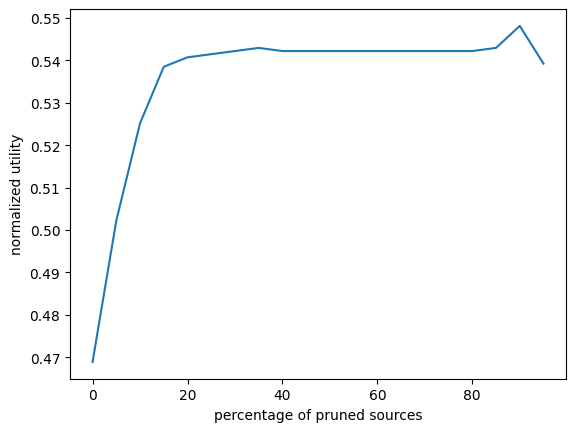

Found best (normalized) utility of 0.5481481481481482 on validation set with threshold 0.5139479834301458, removing 90 percent of domains


In [9]:
import matplotlib.pyplot as plt

percentile_range = range(0, 100, 5)

tuning_result = tune_pruning_threshold(validation, domain_weights, percentile_range, 
                                       utility, group, k, normalize=True)

plt.plot(percentile_range, tuning_result.achieved_utilities)     
plt.ylabel('normalized utility')
plt.xlabel('percentage of pruned sources')
plt.show()
        
print(f'Found best (normalized) utility of {tuning_result.best_utility} on validation set ' +
      f'with threshold {tuning_result.best_threshold}, ' + 
      f'removing {tuning_result.best_percentile} percent of domains')        

In [10]:
evaluate(test, utility, k, normalize=True)

0.4777777777777778

In [11]:
evaluate_pruned(test, utility, group, k, tuning_result.best_threshold, domain_weights, normalize=True)

0.5281481481481481